In [2]:
# Importations et réglage de la reproductibilité
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Pour la reproductibilité
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
!pip install gradio

In [3]:
# Fonctions d'extraction et de chargement du dataset UTKFace
def extract_age_gender(filename):
    """Extrait l'âge et le genre du nom de fichier UTKFace."""
    parts = filename.split("_")
    age = int(parts[0])
    gender = int(parts[1])
    return age, gender

def load_dataset(image_folder):
    """Charge les chemins d'image et labels depuis le dossier UTKFace."""
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    ages, genders = zip(*[extract_age_gender(f) for f in image_files])
    return image_paths, list(ages), list(genders)

# Définir le chemin vers le dataset
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
image_paths, ages, genders = load_dataset(DATA_DIR)

# Mélanger les données
image_paths, ages, genders = shuffle(image_paths, ages, genders, random_state=42)

# Séparation en ensembles train et validation (80% / 20%)
train_paths, val_paths, train_ages, val_ages, train_genders, val_genders = train_test_split(
    image_paths, ages, genders, test_size=0.2, random_state=42
)

print("Nombre d'images d'entraînement :", len(train_paths))
print("Nombre d'images de validation   :", len(val_paths))

Nombre d'images d'entraînement : 18966
Nombre d'images de validation   : 4742


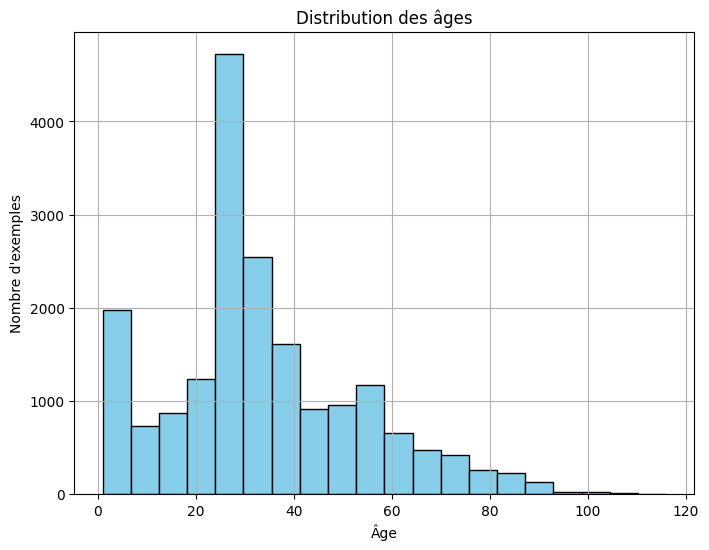

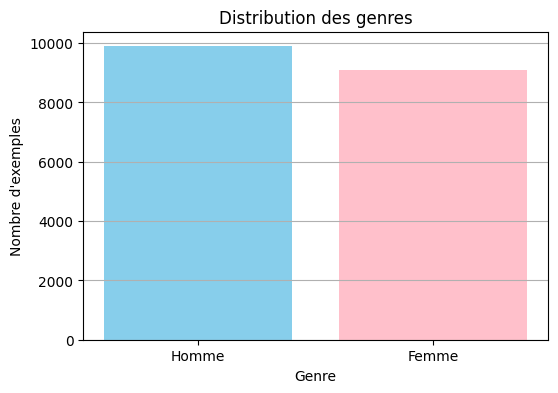

In [4]:
# Visualisation des distributions (utile pour comprendre le dataset)
def plot_age_distribution(ages):
    plt.figure(figsize=(8, 6))
    plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution des âges")
    plt.xlabel("Âge")
    plt.ylabel("Nombre d'exemples")
    plt.grid(True)
    plt.show()

def plot_gender_distribution(genders):
    gender_labels = ["Homme", "Femme"]
    counts = [genders.count(0), genders.count(1)]
    plt.figure(figsize=(6, 4))
    plt.bar(gender_labels, counts, color=['skyblue', 'pink'])
    plt.title("Distribution des genres")
    plt.xlabel("Genre")
    plt.ylabel("Nombre d'exemples")
    plt.grid(axis='y')
    plt.show()

plot_age_distribution(train_ages)
plot_gender_distribution(train_genders)

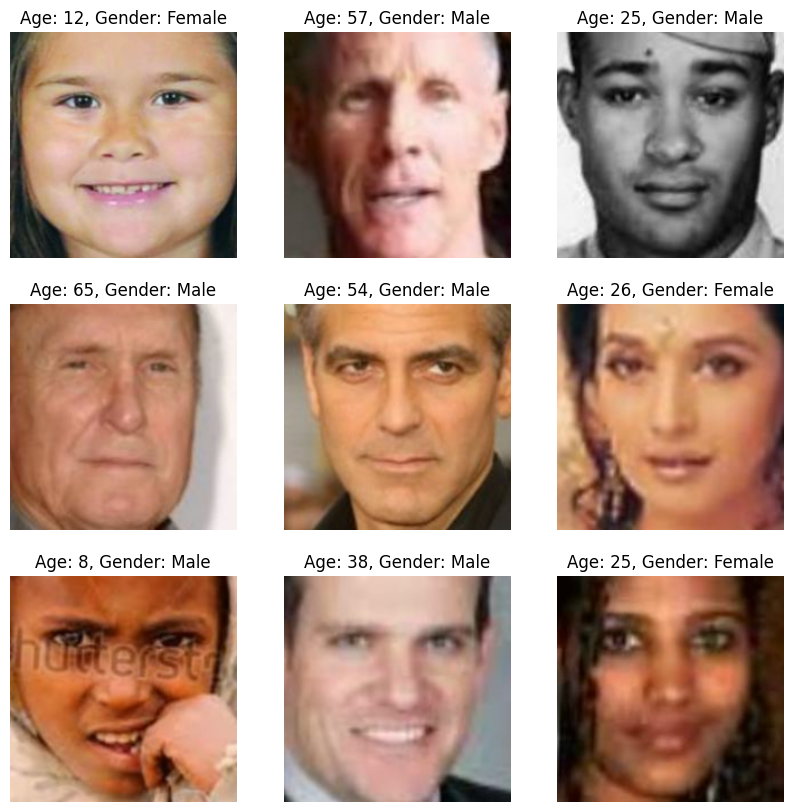

In [5]:
# --- Fonctions de prétraitement ---
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

def process_path_train(path, age, gender, image_size=IMAGE_SIZE):
    """Prétraitement pour l'entraînement avec data augmentation et EfficientNet preprocessing."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = efficientnet_preprocess(image) # Use EfficientNet preprocessing
    normalized_age = tf.cast(age, tf.float32) / 116.0 # Normalize age to [0, 1]
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

def process_path_val(path, age, gender, image_size=IMAGE_SIZE):
    """Prétraitement pour la validation avec EfficientNet preprocessing (sans augmentation)."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = efficientnet_preprocess(image) # Use EfficientNet preprocessing
    normalized_age = tf.cast(age, tf.float32) / 116.0 # Normalize age to [0, 1]
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

# --- Création des datasets ---
def create_dataset(paths, ages, genders, process_func, batch_size=BATCH_SIZE, shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices((paths, ages, genders))
    ds = ds.map(lambda p, a, g: process_func(p, a, g, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(shuffle_buffer) # Shuffle only for training dataset
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_paths, train_ages, train_genders, process_path_train)
val_ds = create_dataset(val_paths, val_ages, val_genders, process_path_val, shuffle_buffer=1) # No need to shuffle validation

# --- Visualisation d'un batch pour vérifier le prétraitement ---
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display 9 images from the batch
        plt.subplot(3, 3, i + 1)
        image = tf.keras.preprocessing.image.array_to_img(images[i]) # Convert back to PIL image for display if needed
        plt.imshow(image)
        age = labels['age_output'][i].numpy() * 120
        gender = "Female" if labels['gender_output'][i].numpy() >= 0.5 else "Male"
        plt.title(f"Age: {age:.0f}, Gender: {gender}")
        plt.axis('off')
    plt.show()

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2

IMAGE_SIZE = (224, 224)
L2_FACTOR = 0.0005
DROPOUT_RATE = 0.3

# Input layer
input_tensor = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# EfficientNetB2 base model
base_model_efficientnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model_efficientnet.trainable = False

# --- Custom Classification Head ---
x = base_model_efficientnet(input_tensor)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

# Dense layers
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x)
x = layers.Dropout(DROPOUT_RATE)(x)

# Output layers
age_output = layers.Dense(1, activation='linear', name='age_output')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

# Create the model
model_efficientnetb0 = Model(inputs=input_tensor, outputs=[age_output, gender_output])

# Model summary
model_efficientnetb0.summary()

# Compile the model
model_efficientnetb0.compile(optimizer=Adam(learning_rate=1e-4),
                     loss={'age_output': 'mae', 'gender_output': 'binary_crossentropy'},
                     metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        327,936 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [7]:
# Entraînement du modèle avec callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint(filepath='/kaggle/working/checkpoints/best_efficientnetb0_age_gender.keras',
                    monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

history_efficientnet = model_efficientnetb0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, # Increased epochs
    callbacks=callbacks
)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - age_output_loss: 0.8939 - age_output_mae: 0.8939 - gender_output_accuracy: 0.7560 - gender_output_loss: 0.5046 - loss: 1.6112
Epoch 1: val_loss improved from inf to 0.89300, saving model to /kaggle/working/checkpoints/best_efficientnetb0_age_gender.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 89s 110ms/step - age_output_loss: 0.8937 - age_output_mae: 0.8937 - gender_output_accuracy: 0.7561 - gender_output_loss: 0.5045 - loss: 1.6108 - val_age_output_loss: 0.3424 - val_age_output_mae: 0.3418 - val_gender_output_accuracy: 0.8564 - val_gender_output_loss: 0.3411 - val_loss: 0.8930 - learning_rate: 1.0000e-04
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - age_output_loss: 0.5907 - age_output_mae: 0.5907 - gender_output_accuracy: 0.8334 - gender_output_loss: 0.3761 - loss: 1.1745
Epoch 2: val_loss improved from 0.89300 to 0.80440, saving model to /kaggle/working/checkpoints/best_efficientnetb0_age_gender.keras
593/593 ━━━━━━━━━━━━━━━━━━━━

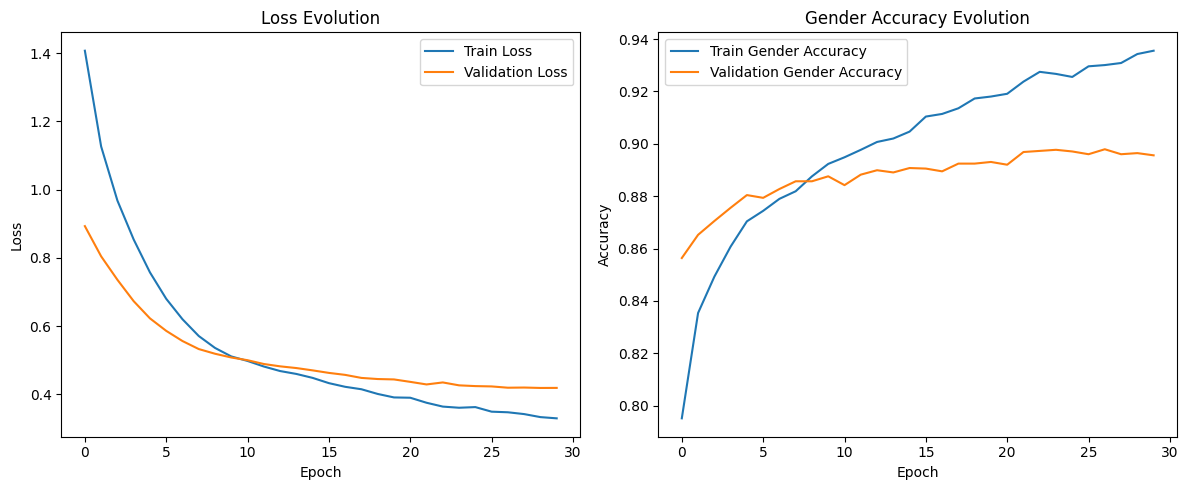

In [8]:
# Visualisation des courbes d'apprentissage
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['gender_output_accuracy'], label='Train Gender Accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Validation Gender Accuracy')
    plt.title('Gender Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_efficientnet)

149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - age_output_loss: 0.0641 - age_output_mae: 0.0641 - gender_output_accuracy: 0.9025 - gender_output_loss: 0.2466 - loss: 0.4063
Validation Loss (Total): 0.4183841049671173
Validation Age MAE: 0.06319291144609451
Validation Gender Accuracy: 0.8964571952819824
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━

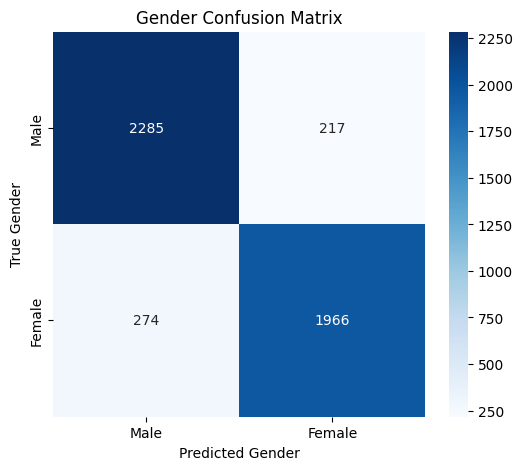

In [10]:
# Évaluation détaillée sur l'ensemble de validation
def evaluate_gender_performance(model, val_ds):
    """Evaluates gender classification and prints metrics."""
    true_genders = []
    predicted_genders_probs = []
    for images, labels in val_ds:
        true_genders.extend(labels['gender_output'].numpy())
        predicted_gender_probs_batch = model.predict(images)[1] # Index 1 for gender
        predicted_genders_probs.extend(predicted_gender_probs_batch.flatten())

    predicted_genders = np.round(predicted_genders_probs)
    true_genders = np.array(true_genders)
    predicted_genders = np.array(predicted_genders)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_genders, predicted_genders)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_genders, predicted_genders))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.title('Gender Confusion Matrix')
    plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

results_val = model_efficientnetb0.evaluate(val_ds)
print("Validation Loss (Total):", results_val[0])
print("Validation Age MAE:", results_val[1])
print("Validation Gender Accuracy:", results_val[4]) # Index 4 for gender accuracy

evaluate_gender_performance(model_efficientnetb0, val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


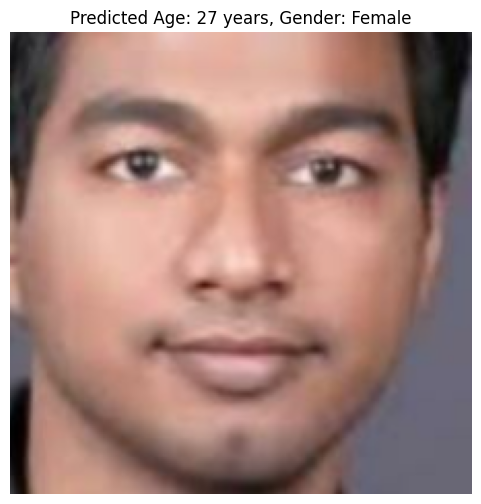

Image Path: /kaggle/input/utkface-new/UTKFace/23_0_3_20170119164051638.jpg.chip.jpg
Predicted Age: 27 years, Predicted Gender: Female


In [14]:
# Fonction d'inférence pour une image à partir du chemin
def inference_age_gender_from_path_v2(model, image_path, image_size=IMAGE_SIZE, plot=False):
    """Inférence âge et genre à partir d'un chemin d'image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = efficientnet_preprocess(image) # Use EfficientNet preprocessing
    input_tensor = tf.expand_dims(image, axis=0) # Add batch dimension
    predictions = model.predict(input_tensor)
    predicted_age_normalized = predictions[0][0][0] # Age output is the first output
    predicted_age = predicted_age_normalized * 120 # Denormalize age
    predicted_gender_prob = predictions[1][0][0] # Gender output is the second output
    predicted_gender = "Female" if predicted_gender_prob >= 0.5 else "Male"

    if plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image)) # Convert back to PIL for display
        plt.title(f"Predicted Age: {predicted_age:.0f} years, Gender: {predicted_gender}")
        plt.axis('off')
        plt.show()
    return predicted_age, predicted_gender

# Exemple d'inférence
sample_image_path = val_paths[np.random.randint(0, len(val_paths))] # Get random val image path
predicted_age, predicted_gender = inference_age_gender_from_path_v2(
    model_efficientnetb0, sample_image_path, plot=True
)
print(f"Image Path: {sample_image_path}")
print(f"Predicted Age: {predicted_age:.0f} years, Predicted Gender: {predicted_gender}")

In [ ]:
# Gradio Interface
def gradio_inference(img):
    """Gradio wrapper function for interactive inference."""
    img_array = np.array(img)
    img_resized = tf.image.resize(img_array, IMAGE_SIZE)
    img_preprocessed = efficientnet_preprocess(img_resized) # Use EfficientNet preprocessing
    input_tensor = tf.expand_dims(img_preprocessed, axis=0)
    predictions = model_efficientnet_v2.predict(input_tensor)
    pred_age = predictions[0][0][0] * 120
    pred_gender_prob = predictions[1][0][0]
    gender_label = "Female" if pred_gender_prob >= 0.5 else "Male"
    return f"Predicted Age: {pred_age:.0f} years, Predicted Gender: {gender_label}"

iface = gr.Interface(
    fn=gradio_inference,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Age and Gender Prediction with EfficientNetB2",
    description="Upload a face image to predict age and gender."
)
iface.launch(share=True)


Métriques de Régression pour l'Âge (Validation):
  MAE : 7.58 ans
  MSE : 108.06
  RMSE: 10.40
  Accuracy within 5 ans: 46.46%
  Accuracy within 10 ans: 73.45%

--- Évaluation par Classes d'Âge ---
Confusion matrix:
[[407 134  71  21   2   0   1   1   0   0   0]
 [  6  77 148  54   5   1   0   0   0   0   0]
 [  0  28 730 509  77   8   1   1   0   0   0]
 [  1   6 286 522 122  25   3   0   1   0   0]
 [  0   3  35 204 165  40   6   0   0   0   0]
 [  0   0  17 107 156 111  41  10   0   0   0]
 [  0   0   3  27  78  75  78  25   5   2   0]
 [  0   0   0   8  12  39  43  27  15   5   1]
 [  0   0   0   1   6  12  22  27  17  11  13]
 [  0   0   0   0   4   5   5   6   7   7   6]
 [  0   0   0   0   0   0   0   1   3   1   2]]


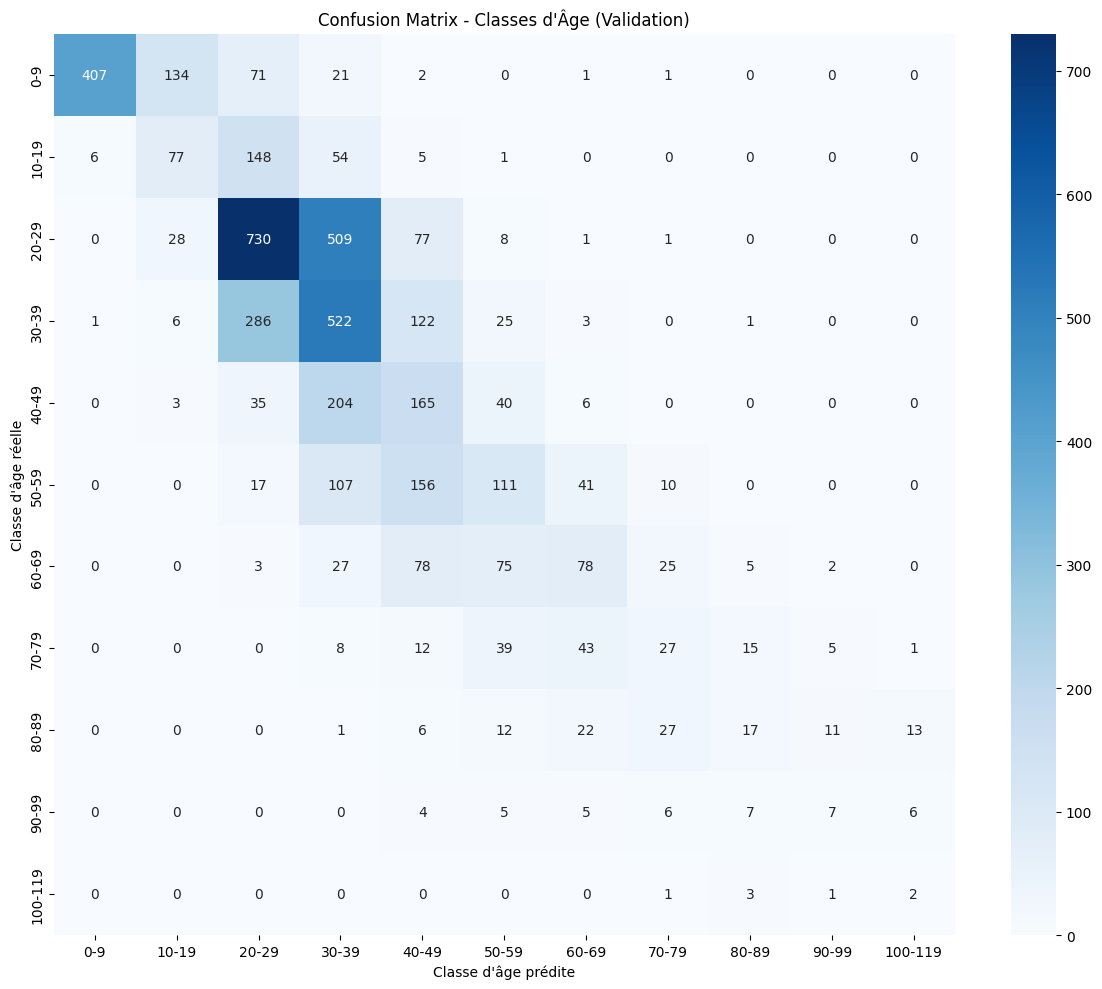


Classification Report (Classes d'Âge):
              precision    recall  f1-score   support

         0-9       0.98      0.64      0.77       637
       10-19       0.31      0.26      0.29       291
       20-29       0.57      0.54      0.55      1354
       30-39       0.36      0.54      0.43       966
       40-49       0.26      0.36      0.31       453
       50-59       0.35      0.25      0.29       442
       60-69       0.39      0.27      0.32       293
       70-79       0.28      0.18      0.22       150
       80-89       0.35      0.16      0.22       109
       90-99       0.27      0.17      0.21        40
     100-119       0.09      0.29      0.14         7

    accuracy                           0.45      4742
   macro avg       0.38      0.33      0.34      4742
weighted avg       0.49      0.45      0.46      4742



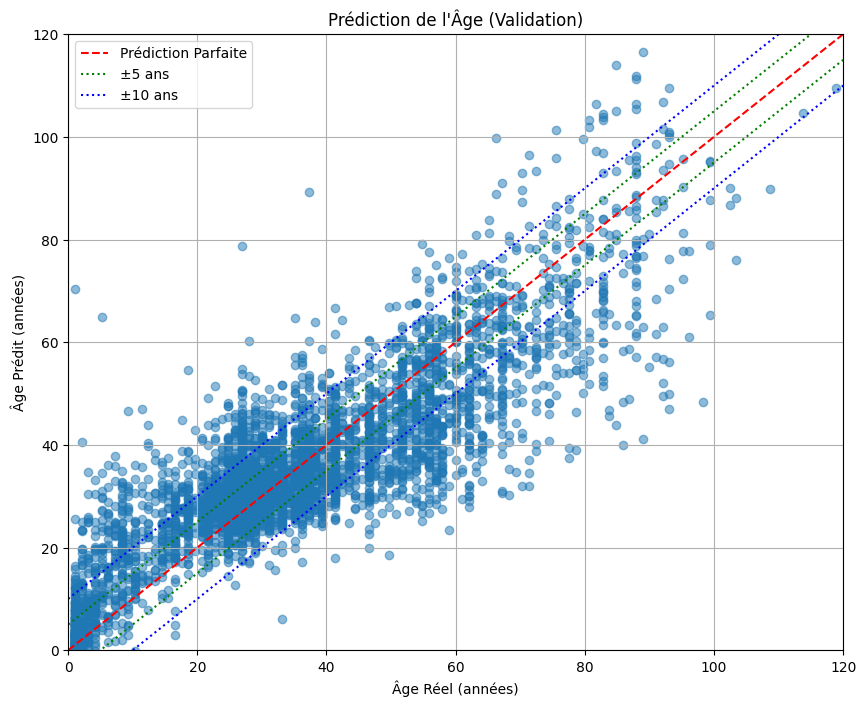

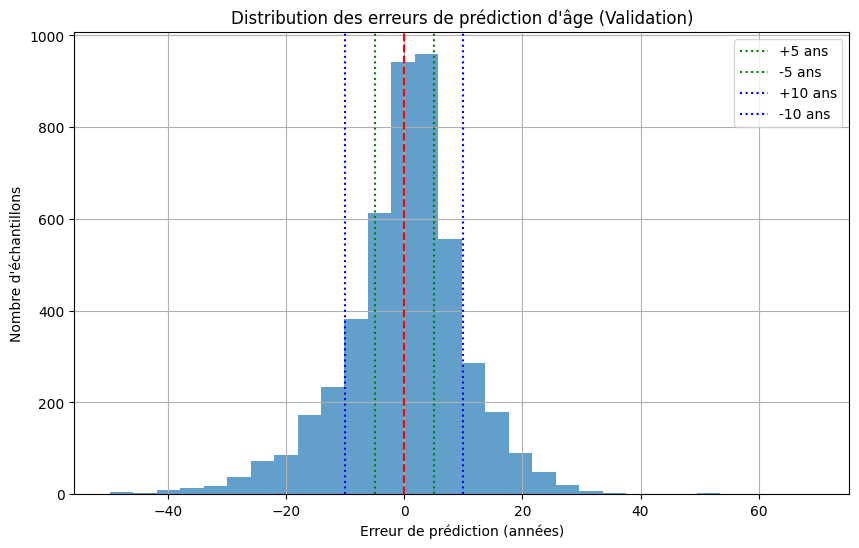

(7.584917,
 0.4645719105862505,
 0.7345002108814846,
 array([[407, 134,  71,  21,   2,   0,   1,   1,   0,   0,   0],
        [  6,  77, 148,  54,   5,   1,   0,   0,   0,   0,   0],
        [  0,  28, 730, 509,  77,   8,   1,   1,   0,   0,   0],
        [  1,   6, 286, 522, 122,  25,   3,   0,   1,   0,   0],
        [  0,   3,  35, 204, 165,  40,   6,   0,   0,   0,   0],
        [  0,   0,  17, 107, 156, 111,  41,  10,   0,   0,   0],
        [  0,   0,   3,  27,  78,  75,  78,  25,   5,   2,   0],
        [  0,   0,   0,   8,  12,  39,  43,  27,  15,   5,   1],
        [  0,   0,   0,   1,   6,  12,  22,  27,  17,  11,  13],
        [  0,   0,   0,   0,   4,   5,   5,   6,   7,   7,   6],
        [  0,   0,   0,   0,   0,   0,   0,   1,   3,   1,   2]]))

In [19]:
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def evaluate_age_performance(model, val_dataset, stage="Validation"):
    """
    Évalue la performance de la prédiction de l'âge :
      - Calcul des métriques de régression (MAE, MSE, RMSE, accuracy within 5 & 10 ans)
      - Conversion des âges continus en classes d'âge et calcul de la confusion matrix.
    """
    true_ages = []
    pred_ages_norm = []
    
    # Collecte des prédictions
    for images, labels in val_dataset:
        true_ages.extend(labels['age_output'].numpy())
        preds = model.predict(images, verbose=0)[0]  # Prédictions de l'âge
        pred_ages_norm.extend(preds.flatten())
    
    # Dénormalisation (assumant une normalisation par 120 comme dans votre code)
    true_ages = np.array(true_ages) * 120.0
    pred_ages = np.array(pred_ages_norm) * 120.0
    
    # Métriques de régression
    mae = mean_absolute_error(true_ages, pred_ages)
    mse = mean_squared_error(true_ages, pred_ages)
    rmse = np.sqrt(mse)
    acc_5 = np.mean(np.abs(true_ages - pred_ages) <= 5.0)  # Accuracy à ±5 ans
    acc_10 = np.mean(np.abs(true_ages - pred_ages) <= 10.0)  # Accuracy à ±10 ans
    
    print(f"\nMétriques de Régression pour l'Âge ({stage}):")
    print(f"  MAE : {mae:.2f} ans")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  Accuracy within 5 ans: {acc_5*100:.2f}%")
    print(f"  Accuracy within 10 ans: {acc_10*100:.2f}%")
    
    # Définition des tranches d'âge
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
    age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]
    
    # Classification des âges en tranches
    true_bin_indices = np.digitize(true_ages, age_bins) - 1
    pred_bin_indices = np.digitize(pred_ages, age_bins) - 1
    
    # Correction des indices hors limites
    true_bin_indices = np.clip(true_bin_indices, 0, len(age_labels)-1)
    pred_bin_indices = np.clip(pred_bin_indices, 0, len(age_labels)-1)
    
    # Conversion des indices en noms de classes
    true_bins = [age_labels[i] for i in true_bin_indices]
    pred_bins = [age_labels[i] for i in pred_bin_indices]
    
    # Matrice de confusion
    print("\n--- Évaluation par Classes d'Âge ---")
    cm = confusion_matrix(true_bins, pred_bins, labels=age_labels)
    print("Confusion matrix:")
    print(cm)
    
    # Visualisation de la matrice de confusion
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=age_labels, yticklabels=age_labels)
    plt.xlabel("Classe d'âge prédite")
    plt.ylabel("Classe d'âge réelle")
    plt.title(f"Confusion Matrix - Classes d'Âge ({stage})")
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_age_{stage.lower()}.png')
    plt.show()
    
    # Rapport de classification
    print("\nClassification Report (Classes d'Âge):")
    print(classification_report(true_bins, pred_bins, labels=age_labels, zero_division=0))
    
    # Scatter plot pour comparer les âges réels et prédits
    plt.figure(figsize=(10, 8))
    plt.scatter(true_ages, pred_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite')
    
    # Ajout des lignes de tolérance pour ±5 ans et ±10 ans
    plt.plot([0, 120], [5, 125], linestyle=':', color='g', label='±5 ans')
    plt.plot([0, 120], [-5, 115], linestyle=':', color='g')
    plt.plot([0, 120], [10, 130], linestyle=':', color='b', label='±10 ans')
    plt.plot([0, 120], [-10, 110], linestyle=':', color='b')
    
    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title(f"Prédiction de l'Âge ({stage})")
    plt.xlim([0, 120])
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_prediction_scatter_{stage.lower()}.png')
    plt.show()
    
    # Histogramme des erreurs
    errors = pred_ages - true_ages
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axvline(x=5, color='g', linestyle=':', label='+5 ans')
    plt.axvline(x=-5, color='g', linestyle=':', label='-5 ans')
    plt.axvline(x=10, color='b', linestyle=':', label='+10 ans')
    plt.axvline(x=-10, color='b', linestyle=':', label='-10 ans')
    plt.xlabel("Erreur de prédiction (années)")
    plt.ylabel("Nombre d'échantillons")
    plt.title(f"Distribution des erreurs de prédiction d'âge ({stage})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_error_distribution_{stage.lower()}.png')
    plt.show()
    
    return mae, acc_5, acc_10, cm


evaluate_age_performance(model_efficientnetb0, val_ds, stage="Validation")